# Image classification using CNN and transfer learning (DenseNet)

## Load data and packages

In [2]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 113.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 147.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 127.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 139.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.7 MB/s eta 0:00:00


In [3]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# #------------tensoflow libraries-----------------
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

Downloaded image dataset from kaggle

In [4]:
!gdown --id 1alX-3H9Hs3DU1H6XPug31skAq7sGUuEE -O jellyfish.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1alX-3H9Hs3DU1H6XPug31skAq7sGUuEE
From (redirected): https://drive.google.com/uc?id=1alX-3H9Hs3DU1H6XPug31skAq7sGUuEE&confirm=t&uuid=7866ed44-515e-4eea-8195-348fae68020e
To: /content/jellyfish.zip
100% 26.8M/26.8M [00:00<00:00, 39.2MB/s]


In [5]:
!unzip -q jellyfish.zip

In [6]:
!ls

barrel_jellyfish   jellyfish.zip	    Moon_jellyfish
blue_jellyfish	   lions_mane_jellyfish     sample_data
compass_jellyfish  mauve_stinger_jellyfish  Train_Test_Valid


Checking image directories, images are saved in various folders, I will use the Train_Test_Valid folder

In [7]:
import os
current_directory = os.getcwd()
print(current_directory)

/content


In [8]:
# check if the directory exists
import os
jellyfish_dir = "/content/Train_Test_Valid"
if os.path.exists(jellyfish_dir):
  print(f"Jellyfish directory found at: {jellyfish_dir}")
else:
  print("Jellyfish directory not found. Please check the path.")

Jellyfish directory found at: /content/Train_Test_Valid


## Image preprocessing and augmentation

In [9]:
def DataCreation(train_dir, test_dir, val_dir, batch_size):
    #data transformations on train images for data augmentation
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                      rescale=1./255,
                      rotation_range=15,
                      width_shift_range=0.2,
                      height_shift_range=0.2,
                      shear_range=0.005,
                      zoom_range=[0.95, 1.2], # try to avoid extreme distortions
                      horizontal_flip=True,
                      vertical_flip=False,
                      brightness_range=(.8,1.2),
                      fill_mode='reflect', # can be a better mode when "nearest" cause distortion
                      )
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0) # no augmentation to the test or validation datasets
    val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

    # images are stored in folder subdirectories so we use .flow_from_directory
    train_generator = train_datagen.flow_from_directory(train_dir,
                                                      shuffle=True,
                                                      target_size = (224,224),
                                                      class_mode = 'categorical', # this performs one-hot encoding
                                                      batch_size = batch_size)
    test_generator = test_datagen.flow_from_directory(test_dir,
                                                      target_size = (224,224),
                                                      class_mode = 'categorical',
                                                      batch_size = batch_size)
    val_generator = val_datagen.flow_from_directory(val_dir,
                                                      target_size=(224, 224),
                                                      batch_size=batch_size,
                                                      class_mode='categorical')
    return train_generator, test_generator, val_generator


In [10]:
train_dir= "/content/Train_Test_Valid/Train"
test_dir= "/content/Train_Test_Valid/test"
val_dir= "/content/Train_Test_Valid/valid"
batch_size= 32

train_generator, test_generator, val_generator = DataCreation(train_dir, test_dir, val_dir, batch_size, )

Found 900 images belonging to 6 classes.
Found 40 images belonging to 6 classes.
Found 39 images belonging to 6 classes.


check that the image augmentations look okay

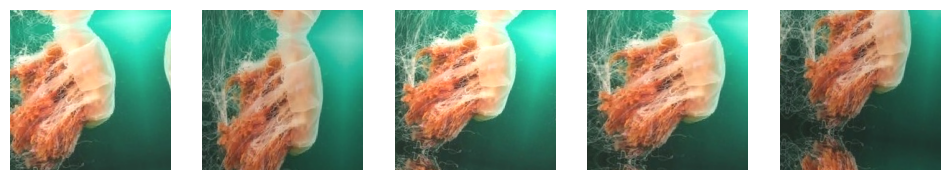

In [11]:
# Plot 5 augmentations of 1st image in train generator
augmented_images = [train_generator[0][0][0] for i in range(5)]

plt.figure(figsize=(12,12))
for i in range(5):
  plt.subplot(1, 5, i+1) # Arrange plots in a single row
  plt.imshow(augmented_images[i]) # Plot the image directly if RGB
  plt.axis('off')

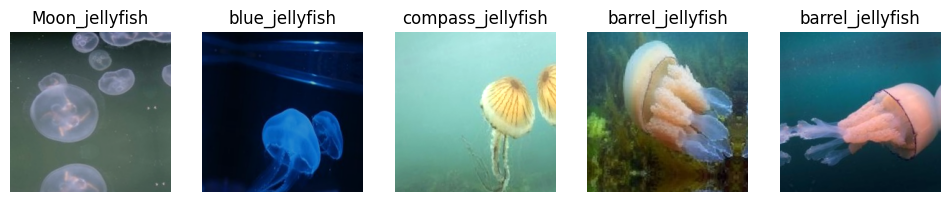

In [12]:
# Get the first batch of images and labels from the train_generator
images, labels = next(train_generator)

# Get the class indices (mapping from label index to class name)
class_indices = train_generator.class_indices

# Plot 5 images with labels
plt.figure(figsize=(12, 12))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    # Get the predicted label index
    predicted_label_index = np.argmax(labels[i])
    # Get the class name using class_indices
    predicted_class_name = list(class_indices.keys())[list(class_indices.values()).index(predicted_label_index)]
    plt.title(predicted_class_name)
    plt.axis('off')

### Defining steps size

Because the data-generators will loop for eternity, we need to specify the number of steps to perform during evaluation and prediction.

The model needs a clear definition of steps per epoch, which is calculated below. This tells Keras how many batches make up ONE FULL EPOCH. One epoch will see each image, or an augmenteed version of it, once. This also means, most epochs will see a different augmented version of the respective image - train_generator with datagen_train is called new for each epoch (it could probably happen that the same arguments are chosen and there are repetitons of augmented images)

In [13]:
steps_train= len(train_generator)
steps_val = len(val_generator)
steps_test = len(test_generator)
num_classes= train_generator.num_classes

steps_train, steps_val, steps_test, num_classes

(29, 2, 2, 6)

## CNN from scratch

In [14]:
from tensorflow.keras import layers, models
import keras

In [15]:
# Build a simple CNN from scratch
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', input_shape=(224,224,3))) # randomly initialize weights based on activation function
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(layers.Dense(512, activation= "relu"))
model.add(tf.keras.layers.Dropout(0.3))
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │   102,761,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,386,790 (394.39 MB)

 Trainable params: 103,386,790 (394.39 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
epochs = 30

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, monitor="val_loss", restore_best_weights=True)
early_stopping_cb

In [17]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(), # because of one-hot encoding
              # otherwise with multiclass prediction we would use SparseCategoricalCrossentropy()
              metrics=['categorical_accuracy']) # and sparse_categorical_accuracy

history = model.fit(train_generator,
                    epochs=epochs,
                    steps_per_epoch=steps_train,
                    validation_data=val_generator,
                    callbacks=[early_stopping_cb]
                    )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 311ms/step - categorical_accuracy: 0.1865 - loss: 1.8580 - val_categorical_accuracy: 0.3846 - val_loss: 1.5826
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 307ms/step - categorical_accuracy: 0.3291 - loss: 1.6274 - val_categorical_accuracy: 0.4103 - val_loss: 1.3484
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 307ms/step - categorical_accuracy: 0.3845 - loss: 1.4898 - val_categorical_accuracy: 0.4103 - val_loss: 1.3003
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 304ms/step - categorical_accuracy: 0.4284 - loss: 1.4024 - val_categorical_accuracy: 0.4615 - val_loss: 1.3301
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 309ms/step - categorical_accuracy: 0.4580 - loss: 1.3758 - val_categorical_accuracy: 0.4103 - val_loss: 1.2285
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 305ms/step - categorical_accuracy: 0.5035 - loss: 1.2721 - val_categorical_accuracy: 0.4615 - val_loss: 1.2418
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 305ms/step - categorical_accuracy: 0.5238 - lo

In [20]:
# Plot the training history.

def plot_history(history_df):
  sns.set(style="ticks", context="talk") # context designed for presentations (larger font etc)
  plt.style.use("dark_background")

  metrics_df = pd.DataFrame(history.history)
  # Plot the training history for 'categorical_accuracy'
  fig, axes= plt.subplots(1, 2, figsize=(10, 6))

  # Plot Accuracy
  sns.lineplot(ax= axes[0], x=metrics_df.index, y=metrics_df['categorical_accuracy'], label='Training Accuracy', color="#17becf")
  sns.lineplot(ax= axes[0], x=metrics_df.index, y=metrics_df['val_categorical_accuracy'], label='Validation Accuracy', color="#ff7f0e")
  axes[0].set_title('Training and Validation Accuracy')
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Accuracy')
  axes[0].set_ylim(0, 1)
  axes[0].legend()

  # Plot Loss
  sns.lineplot(ax= axes[1], x= metrics_df.index, y= metrics_df['loss'], label='Training Loss', color="#17becf")
  sns.lineplot(ax= axes[1], x= metrics_df.index, y= metrics_df['val_loss'], label='Validation Loss', color="#ff7f0e")
  axes[1].set_title('Training and Validation Loss')
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Loss')
  axes[1].set_ylim(0, axes[1].get_ylim()[1])
  axes[1].legend()

  plt.show()

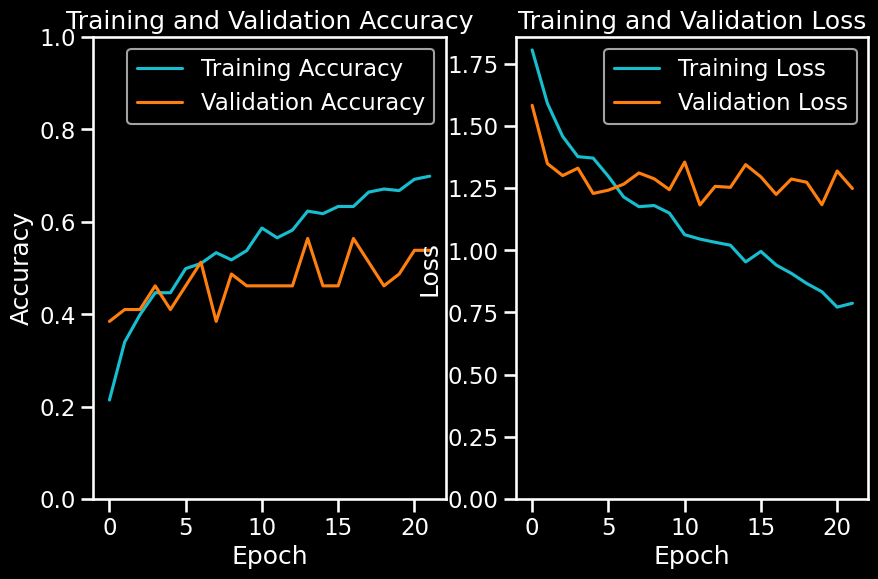

In [21]:
plot_history(history)

In [22]:
# Evaluate the model performance on the test data (use the test_generator defined above)

result = model.evaluate(test_generator, steps=steps_test)
print(f"Test-set classification accuracy: {result[1]:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.6625 - loss: 0.9504
Test-set classification accuracy: 65.00%


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


## Transfer learning (DenseNet)

In [23]:
densenet_base_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
densenet_base_model.trainable = False ## freeze convolutional layers

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [24]:
densenet_base_model.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

### Train new top

In [26]:
densenet_new_model = Sequential()
densenet_new_model.add(densenet_base_model)
densenet_new_model.add(tf.keras.layers.GlobalAveragePooling2D())

densenet_new_model.add(tf.keras.layers.Dense(512, activation='relu'))
densenet_new_model.add(tf.keras.layers.Dropout(0.5))  # Dropout to help with overfitting
densenet_new_model.add(tf.keras.layers.Dense(256, activation='relu'))
densenet_new_model.add(tf.keras.layers.Dropout(0.3))  # Dropout to help with overfitting (originally 0.3)

densenet_new_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [27]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)

densenet_new_model.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics=['categorical_accuracy'])

In [28]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-7)

In [29]:
initial_epochs = 10

history = densenet_new_model.fit(train_generator,
                        epochs=initial_epochs,
                        steps_per_epoch=steps_train,
                        validation_data=val_generator
                        )

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 427ms/step - categorical_accuracy: 0.2267 - loss: 2.1506 - val_categorical_accuracy: 0.4359 - val_loss: 1.5054
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 344ms/step - categorical_accuracy: 0.3101 - loss: 1.6975 - val_categorical_accuracy: 0.6923 - val_loss: 1.2986
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 346ms/step - categorical_accuracy: 0.4735 - loss: 1.3472 - val_categorical_accuracy: 0.6667 - val_loss: 1.1613
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 346ms/step - categorical_accuracy: 0.5305 - loss: 1.2350 - val_categorical_accuracy: 0.6667 - val_loss: 1.0468
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 345ms/step - categorical_accuracy: 0.6300 - loss: 1.0465 - val_categorical_accuracy: 0.6667 - val_loss: 0.9617
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 345ms/step - categorical_accuracy: 0.6283 - loss: 1.0081 - val_categorical_accuracy: 0.6410 - val_loss: 0.9118
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 339ms/step - categorical_accuracy: 0.687

## Unfreeze convolutional layers for fine tuning

In [30]:
densenet_base_model.trainable = True

In [31]:
for layer in densenet_base_model.layers:
  if('conv5' not in layer.name): # only layers from conv5 (the last block) remain trainable
    layer.trainable = False
  if('bn' in layer.name): # do not train batch normalization layers
    layer.trainable = False

In [32]:
optimizer_fine_tuning = Adam(learning_rate=1e-4)

In [33]:
densenet_new_model.compile(loss='categorical_crossentropy', optimizer= optimizer_fine_tuning, metrics=['categorical_accuracy'])

In [34]:
densenet_new_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,695,174 (29.35 MB)

 Trainable params: 2,787,590 (10.63 MB)

 Non-trainable params: 4,907,584 (18.72 MB)

In [35]:
history_fine_tuning = densenet_new_model.fit(train_generator,
                    epochs = 5,
                    steps_per_epoch = steps_train,
                    validation_data = val_generator,
                    callbacks = [early_stopping_cb, lr_scheduler]
                    )

Epoch 1/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 447ms/step - categorical_accuracy: 0.7616 - loss: 0.6370 - val_categorical_accuracy: 0.7179 - val_loss: 0.9879 - learning_rate: 1.0000e-04
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 359ms/step - categorical_accuracy: 0.8391 - loss: 0.4206 - val_categorical_accuracy: 0.6667 - val_loss: 0.9541 - learning_rate: 1.0000e-04
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 350ms/step - categorical_accuracy: 0.8986 - loss: 0.3261 - val_categorical_accuracy: 0.6667 - val_loss: 0.9708 - learning_rate: 1.0000e-04
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 357ms/step - categorical_accuracy: 0.9205 - loss: 0.2134 - val_categorical_accuracy: 0.6410 - val_loss: 1.0358 - learning_rate: 1.0000e-04
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 354ms/step - categorical_accuracy: 0.9244 - loss: 0.1921 - val_categorical_accuracy: 0.7436 - val_loss: 1.0177 - learning_rate: 1.0000e-04


In [36]:
for layer in densenet_base_model.layers:
  # 1. Unfreeze convolutional layers in conv4 and conv5
  if ('conv4' in layer.name or 'conv5' in layer.name) and not 'bn' in layer.name:
    layer.trainable = True
  else:
    layer.trainable = False

  # 2. Freeze Batch Normalization layers
  if 'bn' in layer.name:
    layer.trainable = False

In [37]:
optimizer_fine_tuning = Adam(learning_rate=1e-5)

In [38]:
densenet_new_model.compile(loss='categorical_crossentropy', optimizer= optimizer_fine_tuning, metrics=['categorical_accuracy'])

In [39]:
densenet_new_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,695,174 (29.35 MB)

 Trainable params: 5,589,254 (21.32 MB)

 Non-trainable params: 2,105,920 (8.03 MB)

In [40]:
history_fine_tuning = densenet_new_model.fit(train_generator,
                    epochs = 40,
                    steps_per_epoch = steps_train,
                    validation_data = val_generator,
                    callbacks = [early_stopping_cb, lr_scheduler]
                    )

Epoch 1/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 486ms/step - categorical_accuracy: 0.8974 - loss: 0.2781 - val_categorical_accuracy: 0.6410 - val_loss: 0.9865 - learning_rate: 1.0000e-05
Epoch 2/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 397ms/step - categorical_accuracy: 0.8968 - loss: 0.2675 - val_categorical_accuracy: 0.6667 - val_loss: 0.9214 - learning_rate: 1.0000e-05
Epoch 3/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 406ms/step - categorical_accuracy: 0.9284 - loss: 0.1930 - val_categorical_accuracy: 0.7179 - val_loss: 0.9915 - learning_rate: 1.0000e-05
Epoch 4/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 406ms/step - categorical_accuracy: 0.9347 - loss: 0.1973 - val_categorical_accuracy: 0.7179 - val_loss: 0.9945 - learning_rate: 1.0000e-05
Epoch 5/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 405ms/step - categorical_accuracy: 0.9557 - loss: 0.1456 - val_categorical_accuracy: 0.7179 - val_loss: 1.0288 - learning_rate: 1.0000e-05
Epoch 6/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 402ms/step - categorical_accuracy: 0.9490 - loss: 0.1

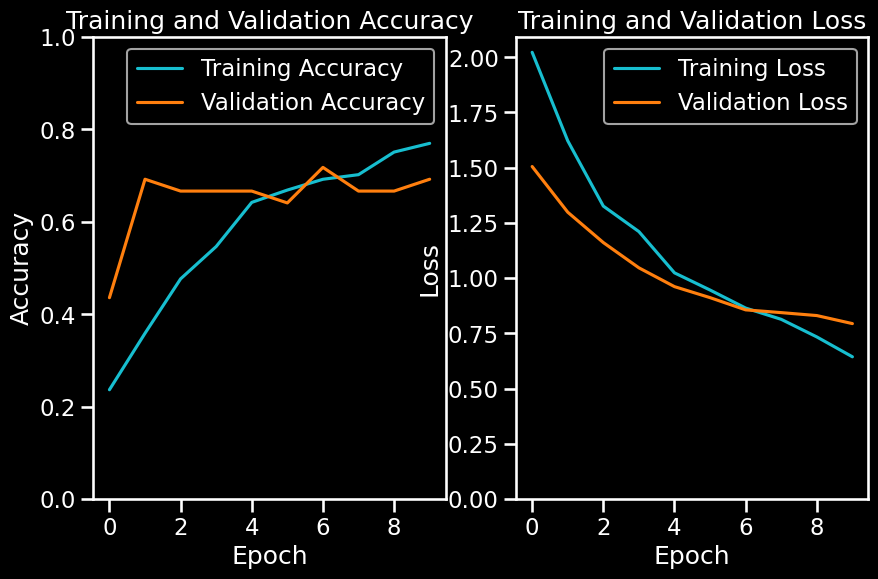

In [41]:
plot_history(history_fine_tuning)

In [44]:
result = densenet_new_model.evaluate(test_generator, steps=steps_test)
print(f"Test-set classification accuracy: {result[1]:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - categorical_accuracy: 0.8917 - loss: 0.3335
Test-set classification accuracy: 0.90
